# Sentiment Analysis of Tweets and Deploying Model for Web Use with Heroku

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import re # regular expression 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Load in the data and do some preprocessing

In [3]:
# Sentiment data can be found on kaggle @ 
data = pd.read_csv('./Sentiment.csv')

# We only care about the "text" and the "sentiment" columns
data = data[['text','sentiment']]
print(data.head())

                                                text sentiment
0  RT @NancyLeeGrahn: How did everyone feel about...   Neutral
1  RT @ScottWalker: Didn't catch the full #GOPdeb...  Positive
2  RT @TJMShow: No mention of Tamir Rice and the ...   Neutral
3  RT @RobGeorge: That Carly Fiorina is trending ...  Positive
4  RT @DanScavino: #GOPDebate w/ @realDonaldTrump...  Positive


## Use RegEx to get rid of unnecessary characters in the Tweets

In [4]:
# Define a function for applying to all the texts 
def preprocess_data(text):
    text = text.lower()
    new_text = re.sub('[^a-zA-Z0-9\s]','',text) # replace anything that's not alphanumeric or a space with empty spaces 
    new_text = re.sub('[rt]', '', new_text) #similarly, get rid of the retweet
    return new_text

# apply to each row with pandas 
data['text'] = data['text'].apply(preprocess_data)
print(data.head())

                                                text sentiment
0   nancyleegahn how did eveyone feel abou he cli...   Neutral
1   scowalke didn cach he full gopdebae las nigh ...  Positive
2   jmshow no menion of ami ice and he gopdebae w...   Neutral
3   obgeoge ha caly fioina is ending  hous afe he...  Positive
4   danscavino gopdebae w ealdonaldump deliveed h...  Positive


## Tokenize and pad the texts

In [5]:
max_features = 2000

tokenizer = Tokenizer(num_words = max_features, split=' ') # Token and keep the 2000 most common words
tokenizer.fit_on_texts(data['text'].to_numpy()) # must be a list of strings 
X = tokenizer.texts_to_sequences(data['text'].values) # convert to a sequence of integers 
X = pad_sequences(X, 28) # truncate at length 28

# check if there are any weird data points in the sentiments
print(data['sentiment'].unique()) # there were no Null values, can proceed to make dummy variables
Y = pd.get_dummies(data['sentiment']).to_numpy()

['Neutral' 'Positive' 'Negative']


## A tiny bit of visualization

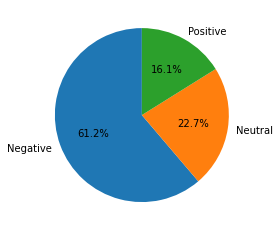

In [6]:
# What does the spread of our data look like? 
import matplotlib.pyplot as plt
sizes = data['sentiment'].value_counts()
labels = sizes.index.values

plt.pie(sizes, labels = labels, autopct='%1.1f%%', startangle = 90)
plt.show()
# maybe the GOP could do with a little more positivity! 
# In seriousness, our data doesn't seem too imbalanced to be an issue

# Building and training the model

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20) # can use sklearn.model_selection method 

# We can also use pandas' sample function, but our data is currently in lists rather than DataFrames

## Design a deep learning model

In [8]:
# To compile under Tensorflow 2, need to downgrade to numpy version 1.19.5
embed_dim = 128
lstm_out = 196

# Design the architecture of the model, use an embedding and some LSTM layers 
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, recurrent_dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))

# Compile the model 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Fit the model

In [11]:
batch_size = 512
history = model.fit(X_train, Y_train, epochs = 10, batch_size = batch_size, validation_data = (X_test, Y_test))

Epoch 1/10
22/22 [==============================] - 14s 622ms/step - loss: 0.5525 - accuracy: 0.7646 - val_loss: 0.8086 - val_accuracy: 0.6814
Epoch 2/10
22/22 [==============================] - 13s 614ms/step - loss: 0.5415 - accuracy: 0.7700 - val_loss: 0.8096 - val_accuracy: 0.6656
Epoch 3/10
22/22 [==============================] - 14s 638ms/step - loss: 0.5311 - accuracy: 0.7724 - val_loss: 0.8114 - val_accuracy: 0.6692
Epoch 4/10
22/22 [==============================] - 14s 642ms/step - loss: 0.5187 - accuracy: 0.7800 - val_loss: 0.8566 - val_accuracy: 0.6724
Epoch 5/10
22/22 [==============================] - 14s 642ms/step - loss: 0.5130 - accuracy: 0.7806 - val_loss: 0.8390 - val_accuracy: 0.6721
Epoch 6/10
22/22 [==============================] - 14s 642ms/step - loss: 0.5003 - accuracy: 0.7872 - val_loss: 0.8628 - val_accuracy: 0.6688
Epoch 7/10
22/22 [==============================] - 15s 661ms/step - loss: 0.4948 - accuracy: 0.7895 - val_loss: 0.8809 - val_accuracy: 0.6645

In [12]:
# Let's save the model! 
model.save('sentiment.h5')

# Visualize performance of the model

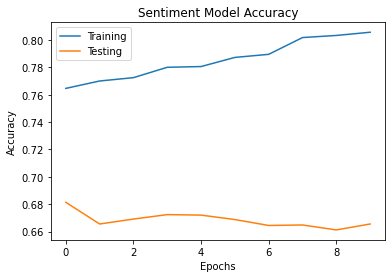

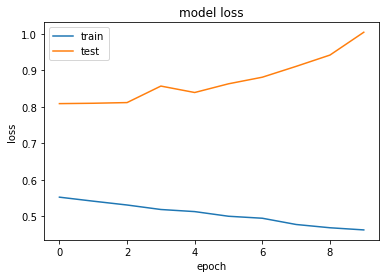

In [17]:
# Let's visualize our model's performance a bit
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Sentiment Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Testing'])
plt.show()

plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()